1. From the Howell1 dataset, consider only the people younger than 13 years
old. Estimate the causal association between age and weight. Assume that
age influences weight through two paths. First, age influences height, and
height influences weight. Second, age directly influences weight through agerelated changes in muscle growth and body proportions.
Draw the DAG that represents these causal relationships. And then write
a generative simulation that takes age as an input and simulates height and
weight, obeying the relationships in the DAG.


In [14]:
import pandas as pd

howell_raw = pd.read_csv("week02/howell.csv", sep=";")

howell = howell_raw.query("age < 13")

howell.describe()

,height,weight,age,male
count,146.000000,146.000000,146.000000,146.000000
mean,98.810729,14.693328,5.401370,0.486301
std,21.489527,5.722741,3.824657,0.501533
min,53.975000,4.252425,0.000000,0.000000
25%,84.455000,10.829509,2.000000,0.000000
50%,98.844100,13.792032,5.000000,0.000000
75%,114.300000,18.335039,8.000000,1.000000
max,147.955000,32.488527,12.000000,1.000000


In [15]:
# Run regresssion age vs weight
import statsmodels.formula.api as smf

model = smf.ols(formula="weight ~ age", data=howell)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     591.1
Date:                Fri, 20 Jan 2023   Prob (F-statistic):           7.81e-53
Time:                        14:54:42   Log-Likelihood:                -342.35
No. Observations:                 146   AIC:                             688.7
Df Residuals:                     144   BIC:                             694.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4461      0.365     20.410      0.0

In [16]:
import numpy as np
import pymc3 as pm
import arviz as az
from quap import quap

height = howell["height"].values
weight = howell["weight"].values
age = howell["age"].values

# Normal with unknown mean and log-variance, with uniform priors 
with pm.Model() as linear_model: 
    # intercept = pm.Uniform("intercept", 1, 8)
    # slope = pm.Uniform("slope", 3, 10)
    intercept = pm.Normal("intercept", 5, 5)
    slope = pm.Normal("slope", 7, 5)
    sigma = pm.Uniform("sigma", 0, 10)
    yobs = pm.Normal("weight", mu=intercept + age * slope, sigma=sigma, observed=weight)
    # trace = pm.sample(3000, return_inferencedata=True)
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=42)


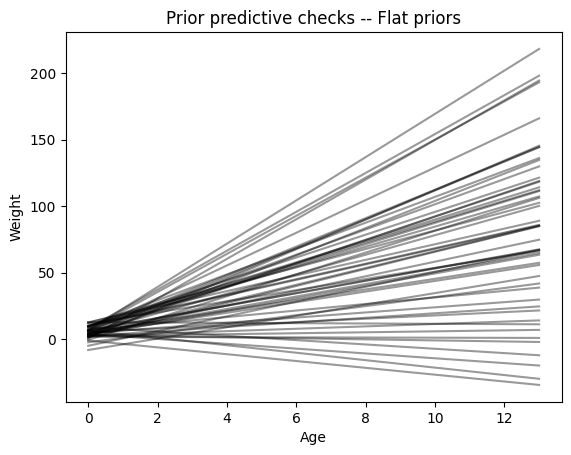

In [17]:
# Plot prior predictive checks
from matplotlib import pyplot as plt

_, ax = plt.subplots()

x_lin = np.linspace(0, 13, 50)

for a, b in zip(prior_checks["intercept"], prior_checks["slope"]):
    y_lin = a + b * x_lin
    ax.plot(x_lin, y_lin, c="k", alpha=0.4)

ax.set_xlabel("Age")
ax.set_ylabel("Weight")
ax.set_title("Prior predictive checks -- Flat priors");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 21 seconds.


array([[<AxesSubplot: title={'center': 'intercept'}>,
        <AxesSubplot: title={'center': 'intercept'}>],
       [<AxesSubplot: title={'center': 'slope'}>,
        <AxesSubplot: title={'center': 'slope'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

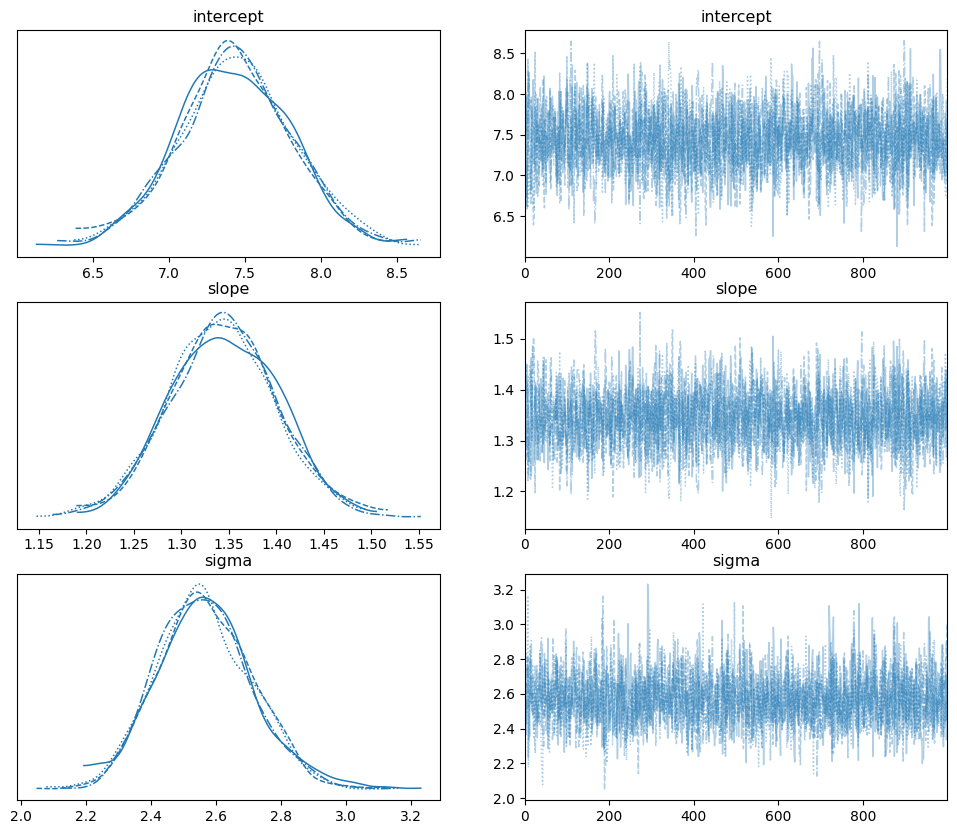

In [18]:
with linear_model:
    trace_1 = pm.sample(1000, tune=2000, random_seed=42, return_inferencedata=True)

az.plot_trace(trace_1, figsize=(12, 10))

In [19]:
with linear_model:
    ppc = pm.sample_posterior_predictive(
        trace_1, var_names=["intercept", "slope", "weight"], random_seed=42
    )

# az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=linear_model))

/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


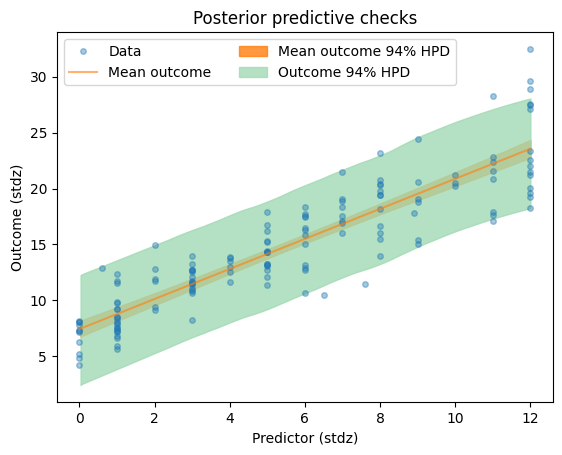

In [20]:
mu_pp = (ppc["intercept"] + ppc["slope"] * age[:, None]).T

_, ax = plt.subplots()

ax.plot(age, weight, "o", ms=4, alpha=0.4, label="Data")
ax.plot(age, mu_pp.mean(0), label="Mean outcome", alpha=0.6)
az.plot_hdi(
    age,
    mu_pp,
    ax=ax,
    fill_kwargs={"alpha": 0.8, "label": "Mean outcome 94% HPD"},
)
az.plot_hdi(
    age,
    ppc["weight"],
    ax=ax,
    fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Outcome 94% HPD"},
)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Outcome (stdz)")
ax.set_title("Posterior predictive checks")
ax.legend(ncol=2, fontsize=10);

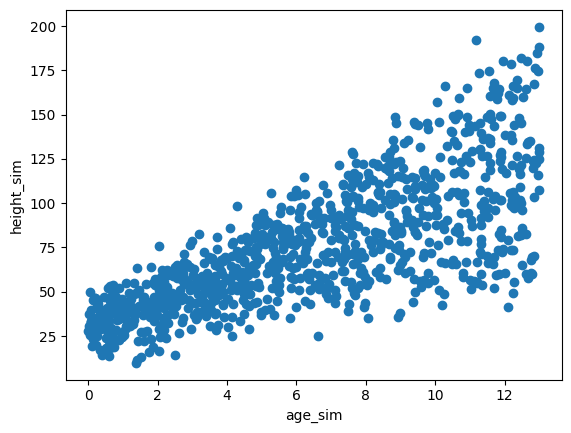

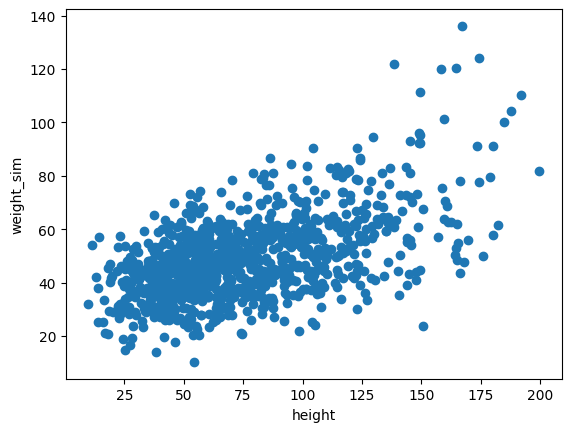

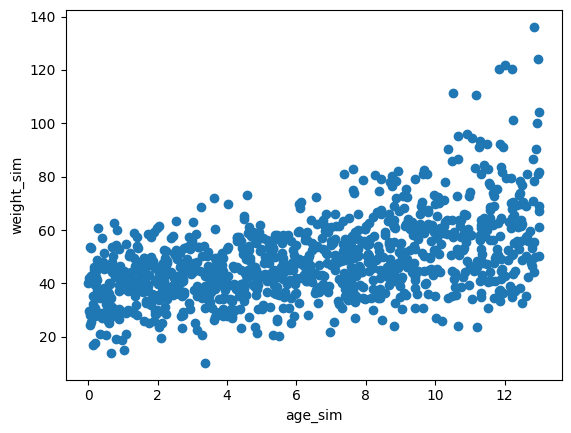

In [21]:
# age -> weight
# age -> height
# height -> weight

# age ~ U(0, 13)
# beta ~ U(0, 20)
# b0 ~ N(0, 10)
# b1 ~ N(0, 10)
# intercept_0 ~ N(120, 100)
# intercept_1 ~ N(60, 10)
# height ~ intercept_0 + age * beta
# weight ~ intercept_1 + height * b0 + age * b1

from matplotlib import pyplot as plt
import numpy as np


n_data = 1000
age_sim = np.random.uniform(0, 13, n_data)
beta = np.random.uniform(2, 12, n_data)
b0 = np.random.uniform(1, 5, n_data)
b1 = np.random.uniform(0, 0.01, n_data)
intercept_0 = np.random.normal(30, 10, n_data)
intercept_1 = np.random.normal(40, 10, n_data)
height_sim = intercept_0 + age_sim * beta
weight_sim = intercept_1 + age_sim * b1 * height_sim * b0

# Plot age_sim vs height_sim, height_sim vs weight_sim, age_sim vs weight_sim

plt.scatter(age_sim, height_sim)
plt.ylabel("height_sim")
plt.xlabel("age_sim")
plt.show()

plt.scatter(height_sim, weight_sim)
plt.ylabel("weight_sim")
plt.xlabel("height")
plt.show()


plt.scatter(age_sim, weight_sim)
plt.ylabel("weight_sim")
plt.xlabel("age_sim")
plt.show()


In [29]:
height

array([121.92  , 105.41  ,  86.36  , 109.22  , 114.3   , 121.92  ,
       128.905 ,  97.79  , 110.49  ,  97.79  , 146.05  ,  91.44  ,
       137.795 , 113.665 , 118.745 , 113.03  , 133.985 , 111.125 ,
       111.76  , 124.46  , 111.76  ,  86.36  ,  74.295 ,  96.52  ,
       116.84  , 100.076 ,  91.44  , 129.54  , 121.92  , 113.665 ,
       120.65  , 115.6   ,  96.52  , 125.095 , 103.505 ,  94.615 ,
       127.635 , 119.38  , 102.235 , 114.3   , 100.965 ,  91.44  ,
       107.95  , 100.965 , 113.03  , 123.19  , 110.49  , 114.3   ,
       120.65  , 106.68  ,  93.98  , 105.41  , 127.    , 111.125 ,
        92.71  , 101.6   , 111.76  ,  85.09  ,  84.455 ,  59.6138,
        92.71  , 111.125 ,  90.805 ,  99.695 ,  62.484 ,  81.915 ,
        96.52  ,  80.01  , 140.6398,  88.265 , 123.825 , 104.14  ,
        97.155 ,  93.345 ,  91.44  ,  60.452 ,  81.28  , 109.22  ,
        71.12  ,  89.2048,  67.31  ,  85.09  ,  69.85  ,  88.9   ,
        90.17  ,  71.755 ,  83.82  , 123.19  ,  74.93  ,  74.2

In [30]:
with pm.Model() as linear_model_height: 

    beta = pm.Uniform("beta", 2, 12)
    b0 = pm.Uniform("b0", 0, 0.01)
    b1 = pm.Uniform("b1", 0, 10)
    intercept_0 = pm.Normal("intercept_0", 30, 10)
    intercept_1 = pm.Normal("intercept_1", 40, 10)
    sigma_height = pm.Normal("sigma_height", 0, 10)
    sigma_weight = pm.Normal("sigma_weight", 0, 10)
    height_obs = pm.Normal("height", intercept_0 + age * beta, sigma_height, observed=height)
    weight_obs = pm.Normal("weight", intercept_1 + age * b1 * height * b0, sigma_weight, observed=weight)

    prior_checks_height = pm.sample_prior_predictive(samples=200, random_seed=42)


Text(0, 0.5, 'Height')

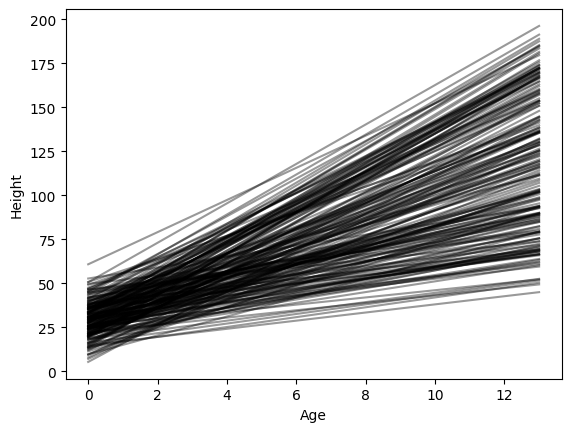

In [31]:
from matplotlib import pyplot as plt

_, ax = plt.subplots()

x_lin = np.linspace(0, 13, 50)

for a, b in zip(prior_checks_height["intercept_0"], prior_checks_height["beta"]):
    y_lin = a + b * x_lin
    ax.plot(x_lin, y_lin, c="k", alpha=0.4)

ax.set_xlabel("Age")
ax.set_ylabel("Height")

Text(0, 0.5, 'Weight')

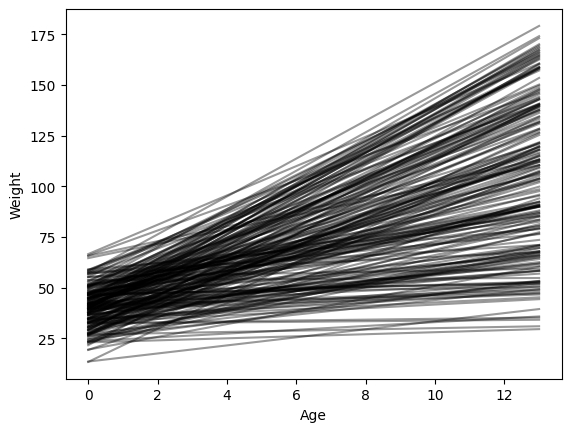

In [33]:
from matplotlib import pyplot as plt

_, ax = plt.subplots()

x_lin = np.linspace(0, 13, 50)

for _i0, _i1, _beta, _b0, _b1 in zip(
    prior_checks_height["intercept_0"],
    prior_checks_height["intercept_1"],
    prior_checks_height["beta"],
    prior_checks_height["b0"],
    prior_checks_height["b1"],

):
    heights = _i0 + _beta * x_lin
    y_lin = _i1 + heights * _b0 + x_lin * _b1
    ax.plot(x_lin, y_lin, c="k", alpha=0.4)

ax.set_xlabel("Age")
ax.set_ylabel("Weight")

2. Use a linear regression to estimate the total causal effect of each year of
growth on weight.


In [ ]:
with linear_model_height:
    trace_height = pm.sample(1000, tune=2000, random_seed=42, return_inferencedata=True)

az.plot_trace(trace_height, figsize=(12, 10))

3. Now suppose the causal association between age and weight might be different for boys and girls. Use a single linear regression, with a categorical
variable for sex, to estimate the total causal effect of age on weight separately
for boys and girls. How do girls and boys differ? Provide one or more posterior contrasts as a summary.


4 - OPTIONAL CHALLENGE. The data in data(Oxboys) (rethinking
package) are growth records for 26 boys measured over 9 periods. I want
you to model their growth. Specifically, model the increments in growth
from one period (Occasion in the data table) to the next. Each increment is
simply the difference between height in one occasion and height in the previous occasion. Since none of these boys shrunk during the study, all of the
growth increments are greater than zero. Estimate the posterior distribution
of these increments. Constrain the distribution so it is always positive—it
should not be possible for the model to think that boys can shrink from year
to year. Finally compute the posterior distribution of the total growth over
all 9 occasions.